<a href="https://colab.research.google.com/github/DavidkingMazimpaka/BTC-Forecasting/blob/main/btc_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab  notebook that demonstrates time series forecasting using Bitcoin (BTC) data.

![](https://media0.giphy.com/media/f67U9Xc53i4ViUs5T2/giphy.gif?cid=ecf05e47h4dpv8s5ppc6omcbb5uzwprey8y97x3fy8qk8dk8&rid=giphy.gif&ct=g)

### Adding Libraries and Downloading Dataset

In [17]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bitcoin-stock-data-sept-17-2014-august-24-2021:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1549839%2F3204533%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240920%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240920T122956Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D95d9c32e9392b78638120fb266bfc274f220669e57a7fb52a92a0b63c8b83b87e06517be8f6800b06372237c1ac52e05b35ffb9e3e7f8520e6f57f162fa889659292ace9c8d74d773377abdf3f44a2c6281f3b60ee788d384808d6c7126d8228dffb9980c15df2969d8d0340da8bd64e3fde88e6ae601a14db0857163891d46a691b2167739eaba2c662e95cdcba5de5305ce840b4b612e279c18c162ee912783c96e9345c0a3ad41271d44be2a2aa11c7a3dd6af3a651d88be3a1c4458d6cb1c6c0f8a7007e94c094fe6cebb21d210b2e8da1c017f1ec3d2d6f8deed3b0db45c86ba7076c0358cca7f6d32610cb4ef683224dbf80628c1a05e296b79d90d2db'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 77757 bytes downloaded
Downloaded and uncompressed: bitcoin-stock-data-sept-17-2014-august-24-2021
Data source import complete.


In [53]:
# First we will import the necessary Library

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from itertools import cycle

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

### Loading and Examining the Data

In [40]:
# Load our dataset
# Note it should be in same dir
# ../input/bitcoin-stock-data-sept-17-2014-august-24-2021/BTC-USD.csv


maindf=pd.read_csv('../input/bitcoin-stock-data-sept-17-2014-august-24-2021/BTC-USD.csv')

In [41]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  2713
Total number of fields present in the dataset:  7


### Checking for Null Values

In [42]:
print('Null Values:',maindf.isnull().values.sum())
print('NA values:',maindf.isnull().values.any())

Null Values: 0
NA values: False


**no null values available**

## EDA(Exploratory Data Analysis)

In [44]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2014-09-17
Ending Date 2022-02-19


### Let's do StockPrice Analysis from Start

In [45]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2014 = maindf.loc[(maindf['Date'] >= '2014-09-17')
                     & (maindf['Date'] < '2014-12-31')]

y_2014.drop(y_2014[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
100,2014-12-26,319.152008,331.424011,316.627014,327.924011
101,2014-12-27,327.583008,328.911011,312.630005,315.863007
102,2014-12-28,316.160004,320.028015,311.078003,317.239014
103,2014-12-29,317.700989,320.266998,312.307007,312.670013


In [46]:
monthvise= y_2014.groupby(y_2014['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,412.654003,407.182428


 we only have few months in 2014 so the rest of the months are **NaN**

In [48]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

Since we have few months in 2014 so the rest of the months are not plotted since we do not have the data

In [56]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_overall = maindf.loc[(maindf['Date'] >= '2014-09-17')
                     & (maindf['Date'] <= '2022-02-19')]

y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
2708,2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125
2709,2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375
2710,2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719
2711,2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563


In [58]:
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,12855.131425,12828.374881
February,12773.077824,12837.802432
March,10918.895761,10957.226324
April,11338.448900,11359.962198
May,10659.455257,10580.209317
June,9299.305977,9294.420703
July,9285.402500,9330.128271
August,11312.971706,11345.157739
September,10489.365578,10462.378150


In [100]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'],
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## Building LSTM Model
### I am considering 1 year data for training data

In [101]:
# Lets First Take all the Close Price
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2713, 2)


In [102]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2014-2022', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [103]:
closedf = closedf[closedf['Date'] > '2021-02-19']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  365


In [104]:
closedf

,Date,Close
2348,2021-02-20,56099.519531
2349,2021-02-21,57539.945313
2350,2021-02-22,54207.320313
2351,2021-02-23,48824.425781
2352,2021-02-24,49705.332031
...,...,...
2708,2022-02-15,44575.203125
2709,2022-02-16,43961.859375
2710,2022-02-17,40538.011719
2711,2022-02-18,40030.976563


In [105]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## Normalizing Data

In [106]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(365, 1)


## Slicing data into Training set and Testing set

In [107]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (219, 1)
test_data:  (146, 1)


## Now we Transform the Close price based on Time-series-analysis forecasting requirement , Here we will take 15

In [108]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

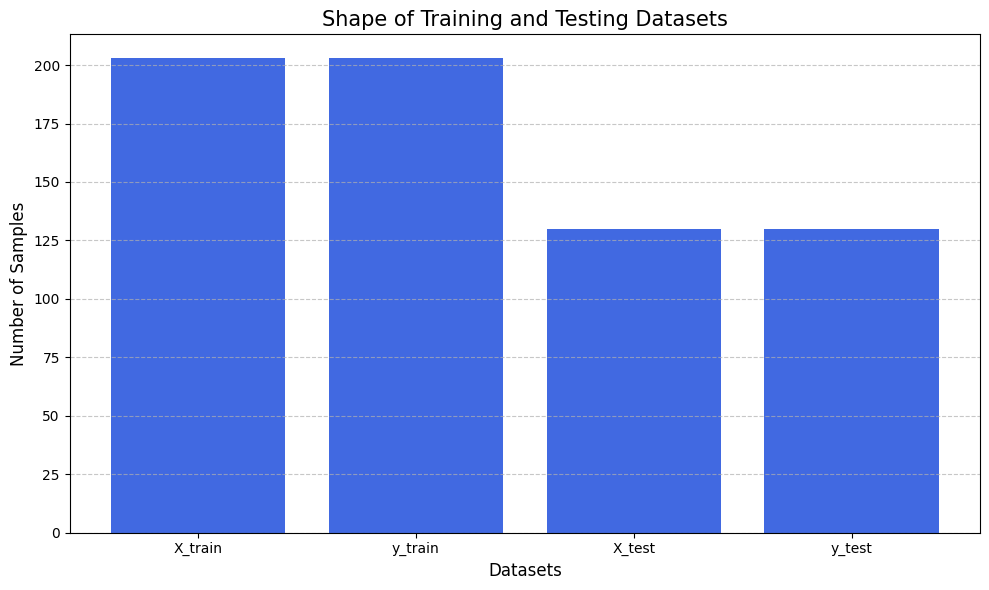

In [109]:
import matplotlib.pyplot as plt

# Assuming these are your shapes from the dataset
X_train_shape = X_train.shape[0]  # Number of samples in X_train
y_train_shape = y_train.shape[0]   # Number of samples in y_train
X_test_shape = X_test.shape[0]     # Number of samples in X_test
y_test_shape = y_test.shape[0]     # Number of samples in y_test

# Prepare data for plotting
labels = ['X_train', 'y_train', 'X_test', 'y_test']
values = [X_train_shape, y_train_shape, X_test_shape, y_test_shape]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='royalblue')

# Add titles and labels
plt.title('Shape of Training and Testing Datasets', fontsize=15)
plt.xlabel('Datasets', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [110]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (203, 15, 1)
X_test:  (130, 15, 1)


## Actuall Model Building

In [111]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [112]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.3454 - val_loss: 0.4745
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3303 - val_loss: 0.4118
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2625 - val_loss: 0.3549
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2263 - val_loss: 0.3015
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1887 - val_loss: 0.2515
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1473 - val_loss: 0.2033
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1258 - val_loss: 0.1569
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0977 - val_loss: 0.1142
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0738 - val_loss: 0.0755
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0494 - val_loss: 0.0417
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0280 - val_loss: 0.0172
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0175 - val_lo

## Plotting Loss vs Validation loss

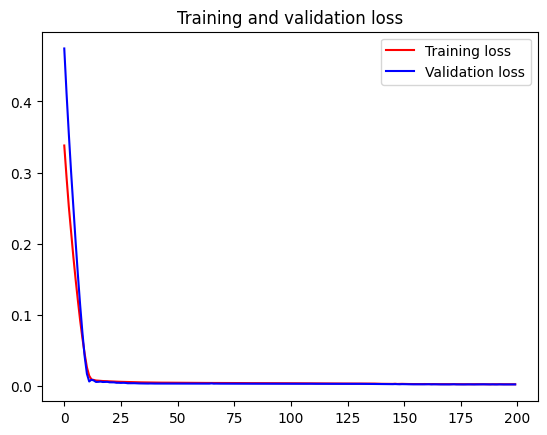

<Figure size 640x480 with 0 Axes>

In [113]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

### prediction and performance metrics

In [114]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


((203, 1), (130, 1))

## Model Evaluation

In [115]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

## Evaluation metrices RMSE, MSE and MAE

In [116]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1887.9166018845806
Train data MSE:  3564229.0956714223
Train data MAE:  1468.6586168509853
-------------------------------------------------------------------------------------
Test data RMSE:  1831.431546424147
Test data MSE:  3354141.5092375427
Test data MAE:  1410.0935997884612


## Variance Regression Score

In [117]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9592671913559145
Test data explained variance regression score: 0.9595891633617022


## R square score for regression

In [118]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.959035693907447
Test data R2 score: 0.9588871944416464


## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [119]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.001804838027874254
Test data MGD:  0.0013123224643499405
----------------------------------------------------------------------
Train data MPD:  78.81549182196133
Test data MPD:  65.23584782971291


## Comparision of original stock close price and predicted close price

In [121]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


## Predicting next 30 days

In [122]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


## Plotting last 15 days of dataset and next predicted 30 days

In [123]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [124]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## Plotting entire Closing Stock Price with next 30 days period of prediction

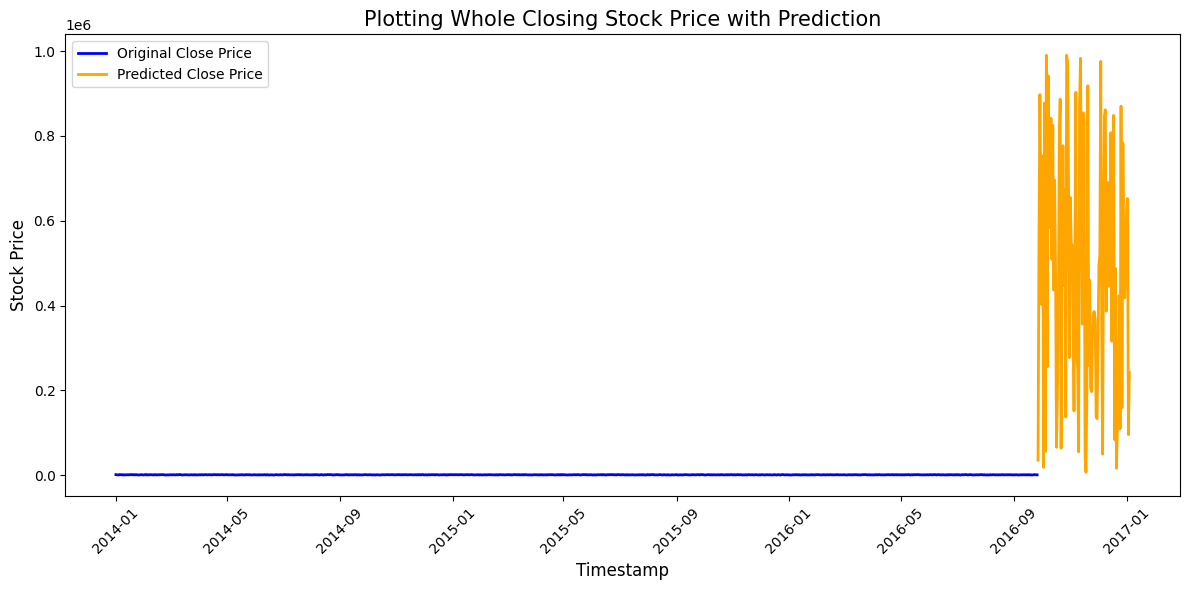

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Example DataFrame creation (replace this with your actual DataFrame)
data = {
    'Date': pd.date_range(start='2014-01-01', periods=1000, freq='D'),
    'Close': np.random.rand(1000) * 1000  # Replace with actual closing prices
}
closedf = pd.DataFrame(data)

# Assuming lst_output is your prediction output
# lst_output should be defined, here is a sample (replace it with your actual predictions)
lst_output = np.random.rand(100) * 1000  # Example predictions

# Initialize the scaler (fit it on the original close prices)
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(closedf[['Close']])

# Convert the 'Close' column to a list and extend with predictions
lstmdf = scaled_close.flatten().tolist()  # Get the scaled 'Close' column as a list
lstmdf.extend((np.array(lst_output).reshape(-1, 1)).flatten().tolist())  # Append predictions

# Inverse transform lstmdf (make sure it's a 2D array for inverse_transform)
lstmdf = scaler.inverse_transform(np.array(lstmdf).reshape(-1, 1)).flatten().tolist()  # Inverse transform

# Prepare data for plotting
dates = closedf['Date'].tolist()  # Use the 'Date' column for x-axis
combined_data = lstmdf

# Create the plot
plt.figure(figsize=(12, 6))

# Plot original close prices
plt.plot(dates[:len(combined_data) - len(lst_output)], combined_data[:len(combined_data) - len(lst_output)],
         color='blue', linewidth=2, label='Original Close Price')

# Plot predicted close prices
predicted_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=len(lst_output), freq='D')  # Generate dates for predictions
plt.plot(predicted_dates, combined_data[len(dates):], color='orange', linewidth=2, label='Predicted Close Price')

# Customize the plot
plt.title('Plotting Whole Closing Stock Price with Prediction', fontsize=15)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.xticks(rotation=45)
plt.grid(False)
plt.gca().set_facecolor('white')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()